# Exploratory Data Analysis

The approach is as follows:
1. Clean the data
2. Categorize the data
3. Perform univariate analysis for each feature in each category
4. Perform bivariate/multivariate analysis using features in the same category
5. Perform domain-specific analysis for the category
6. Perform bivariate/multivariate analysis using features across different categories

Note: This notebook uses ipywidgets to create interactive plots. If you are viewing this notebook on GitHub, the interactive plots will not be displayed. To view the interactive plots, please clone the repository and run it locally.

## 1. Import Python packages

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import re

## 2. Loading and Categorizing the Dataset

In [40]:
data = pd.read_csv('data/Family Income and Expenditure.csv')

### 2.1 Cleaning region names

For visualization purposes, the regions will be represented by their numbers. ' ARMM' will also be changed to 'ARMM'.

In [41]:
from utils.data_utils import clean_region_names
data = clean_region_names(data)
print(data['Region'].unique())

['CAR' 'XIII' 'VI' 'V' 'ARMM' 'III' 'II' 'IV-A' 'VII' 'X' 'XI' 'VIII' 'I'
 'NCR' 'IV-B' 'XII' 'IX']


### 2.2 Correcting misspelled columns

In [42]:
data.rename(columns={"Total Income from Entrepreneurial Acitivites": "Total Income from Entrepreneurial Activities"}, inplace=True)

### 2.2 Handling missing values

In [43]:
from utils.data_utils import handle_missing_values
data = handle_missing_values(data)

Columns with Missing Values:
Household Head Occupation         7536
Household Head Class of Worker    7536
Toilet Facilities                 1580
dtype: int64


### 2.3 Removing the outliers
Outliers were determined using the z-scores of the total household income. This was decided upon after its visualization with a histogram, but was placed in here to keep the notebook organized.

In [44]:
from utils.data_utils import remove_income_outlier
data = remove_income_outlier(data)

### 2.4 Categorizing the data

In [45]:
from utils.data_utils import get_expenditures_data, get_income_data, get_householdhead_data, get_appliances_data, get_property_information, get_family_composition

expenditures_data = get_expenditures_data(data)
income_data = get_income_data(data)
householdhead_data = get_householdhead_data(data)
appliances_data = get_appliances_data(data)
property_data = get_property_information(data)
family_composition_data = get_family_composition(data)

# Checking if all of the columns have been categorized 
collection = expenditures_data +  income_data + appliances_data +  householdhead_data + family_composition_data +  property_data
missing = [element for element in data.columns if element not in collection]
print(missing)


['Region']


The only data column missing from the collection is 'Region', which does not need to be categorized. Thus, we know that all of the columns have been categorized.

#### 2.4.1 Categorizing the data based on data type

In [46]:
from utils.data_utils import categorize_by_datatype
categorical_columns, continuous_columns, binary_columns, counting_columns = categorize_by_datatype(data)

## 3. Exploring the Total Household Income

We seek to answer the following questions:

1. What are the regions with the highest and lowest average family income?
2. What region has the highest poverty incidence?
3. What region has the highest income inequality?

### 3.1 Total Household Income Distribution

In [47]:
regions = data['Region'].unique()
regions = np.append(regions, 'Philippines')

In [48]:
from utils.histogram_utils import plot_histogram
from utils.bar_utils import bar_chart_regional_average, stacked_bar
from ipywidgets import interact, fixed

#### 3.1.1. Distribution of total household income in the Philippines and in each region region

In [49]:
interact(plot_histogram, data=fixed(data), key=fixed('Total Household Income'), figsize=fixed((10, 5)), region=regions)

interactive(children=(Dropdown(description='region', options=('CAR', 'XIII', 'VI', 'V', 'ARMM', 'III', 'II', '…

<function utils.histogram_utils.plot_histogram(data, key, region='Philipines', figsize=(5, 3))>

#### 3.1.2. Side-by-side comparison of average household income in each region

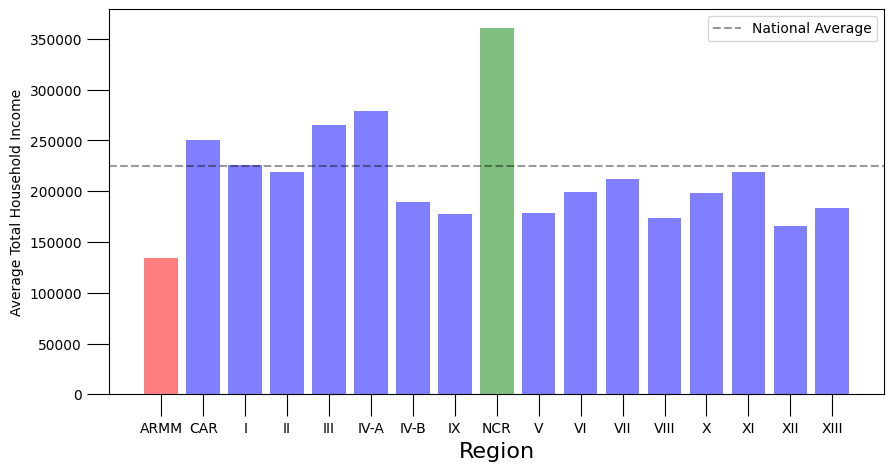

In [50]:
bar_chart_regional_average(data, 'Total Household Income')

Among the regions, NCR had the highest average total household income. This is expected due to the region's status as the country's economic and political center, leading to the availability of more lucrative jobs. Meanwhile, ARMM had the the lowest average total household income which may be due to the political instability in the region.

### 3.1.1 Choropleth map

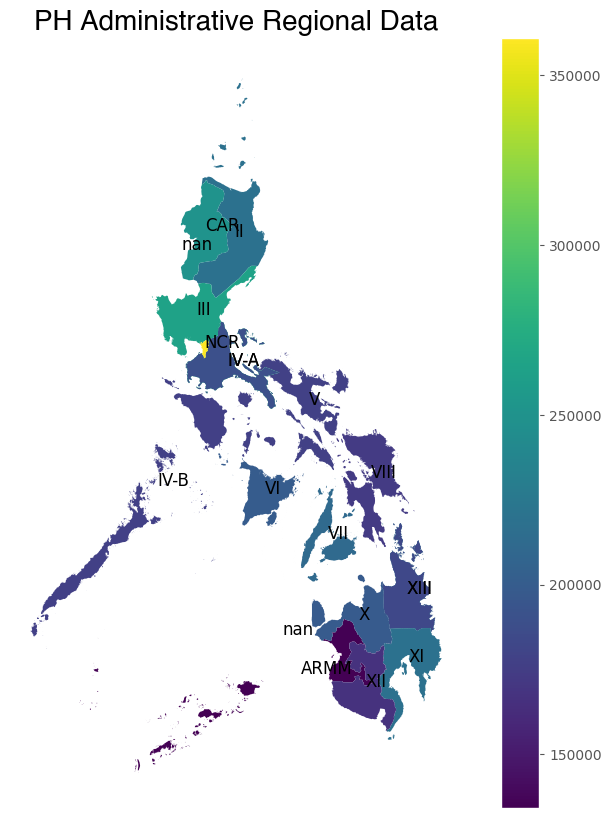

In [102]:
from utils.choropleth_utils import load_regions_geodataframe, regional_averages_name_clean, choropleth
regions_gdf_clean = load_regions_geodataframe()
# Adding regional averages to the regions_clean dataframe
merged_df = pd.merge(regions_gdf_clean, regional_averages, left_on='REGION', right_on='Region', how='left')
choropleth(merged_df, 'Total Household Income')

The National Capital Region (NCR) had the brightest color for the total household income. There is a gradual spread of brightness from NCR which implies that NCR's economic prosperity influences its neighboring regions to some extent. The economic activity and opportunities in the capital appear to have a ripple effect, albeit diminishing, on the adjacent areas.

This map also showcases the geographical features of the capital city of Manila, i.e. the natural harbor. This natural harbor has historically played a crucial role in the economic development of the National Capital Region. The presence of a well-positioned natural harbor in Manila has facilitated trade and commerce, making it a hub for maritime activities. This advantage has attracted businesses, industries, and investments to the region over time.

### 3.2 Main Sources of Income

#### 3.2.1 Main sources of Income in the Philippines

<Axes: xlabel='Main Source of Income'>

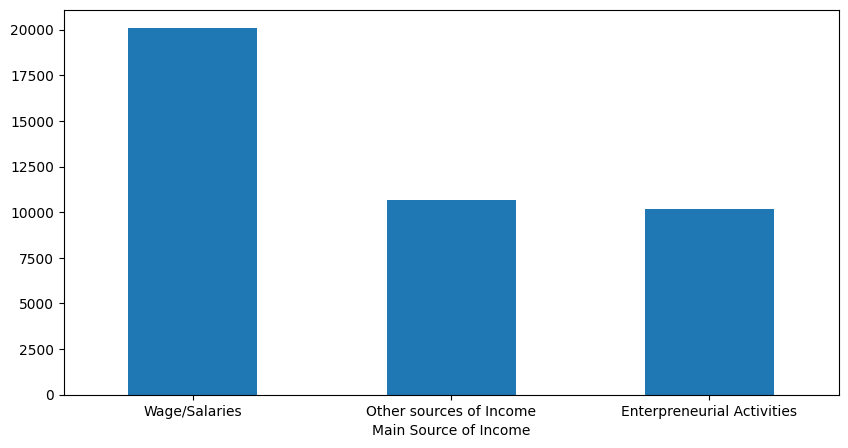

In [51]:
data['Main Source of Income'].value_counts().plot(kind='bar', figsize=(10, 5), rot=0)

#### 3.2.2 Main Sources of Income per Region

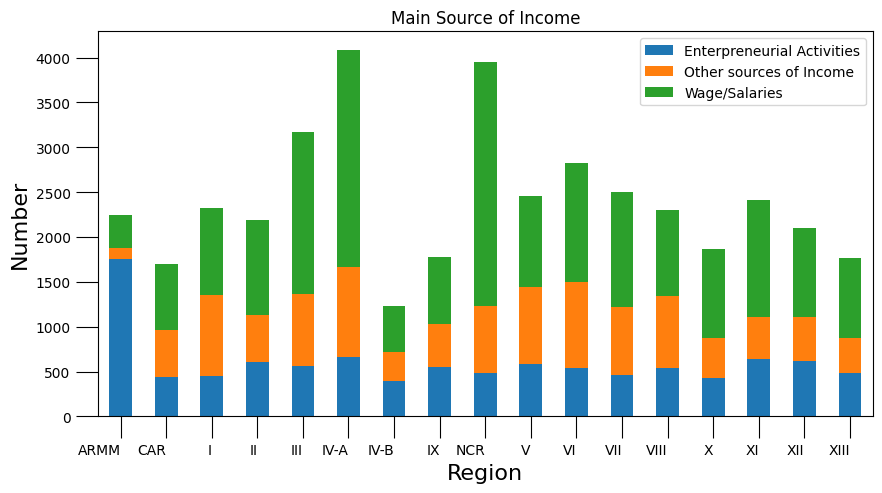

In [53]:
stacked_bar(data, 'Main Source of Income')

In [61]:
# Write code to plot the % of wage/salaries per region
def percentage_wage(region):
    wage = data[data['Region'] == region]['Main Source of Income'].value_counts()['Wage/Salaries']
    total = data[data['Region'] == region]['Main Source of Income'].value_counts().sum()
    return wage/total


def create_dataframe_percentage_wage(data, keys):
    """Return a dataframe with the highest / lowest average value for the given data column."""
    max_min = {}
    for key in keys:
        percentage = percentage_wage(key)
        max_min.update({key: [percentage]})

    return pd.DataFrame(max_min)


### 3.3 Total Household Income from Entrepreneural Activities

#### 3.3.1. Distribution of income from entrepreneurial activities in the Philippines and per region

In [15]:
interact(plot_histogram, data=fixed(data), key=fixed('Total Income from Entrepreneurial Activities'), figsize=fixed((10, 5)), region=regions)

interactive(children=(Dropdown(description='region', options=('CAR', 'XIII', 'VI', 'V', 'ARMM', 'III', 'II', '…

<function utils.histogram_utils.plot_histogram(data, key, region='Philipines', figsize=(5, 3))>

#### 3.3.2. Side-by-side comparison of average household income from entrepreneurial activities in each region

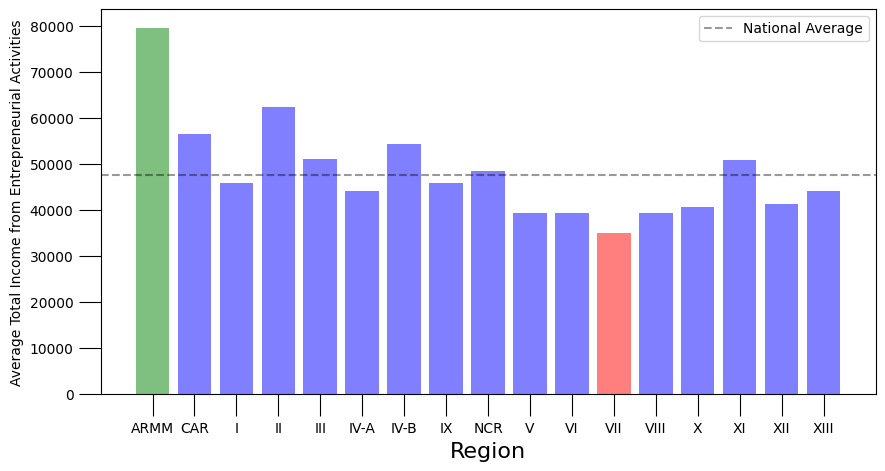

In [16]:
bar_chart_regional_average(data, 'Total Income from Entrepreneurial Activities')

ARMM relied mostly on entrepreneurial activites as their main source of income. The ARMM region, situated in the southern part of the Philippines, had encountered challenges such as underdeveloped infrastructure, limited access to quality education, and a history of conflict. These factors made it more difficult for traditional industries to thrive and led to a higher reliance on entrepreneurial endeavors.

### 3.4 Relating Total Household Income and Income from Entrepreneurial Activities

In [21]:
from utils.scatter_utils import basic_scatter_plot, regional_scatter_plot

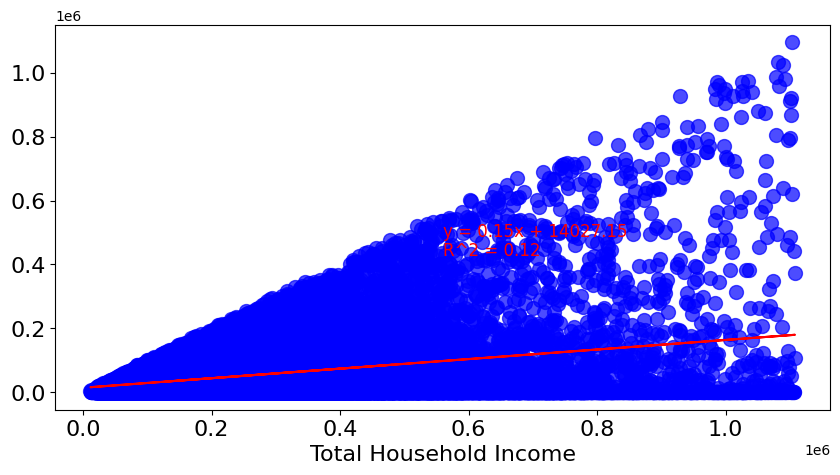

In [18]:
basic_scatter_plot(data['Total Household Income'], data['Total Income from Entrepreneurial Activities'])

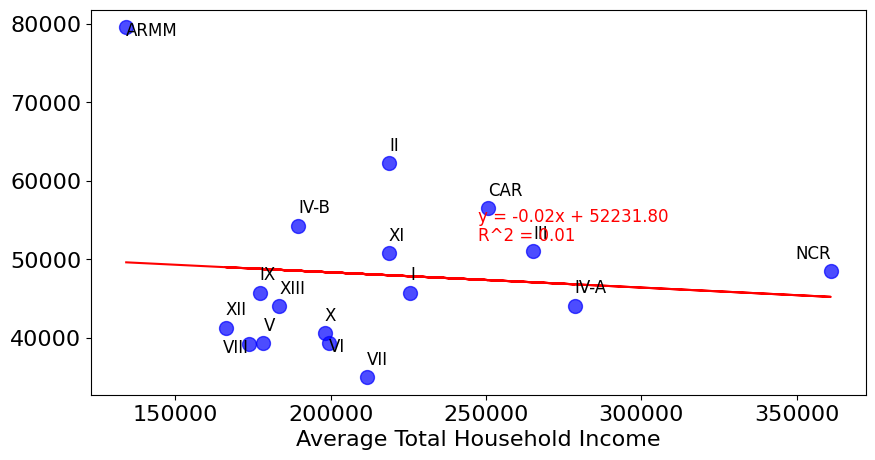

In [28]:
regional_scatter_plot(data, 'Total Income from Entrepreneurial Activities')

There is very weak correlation between the total household income and income from entrepreneurial activities.

### 3.4 Deeper Exploration

#### 3.4.1 Number of people below the poverty threshold

The poverty threshold in the Philippines in 2015 is a monthly income of P9,064 according to [PSA](https://rsso11.psa.gov.ph/sites/default/files/attachments/Special%20Release%20Poverty%202015.pdf). This is the income needed to meet their most basic food and non-food needs.

In [ ]:
def bar_plot_below_poverty_line(data, key):
    below_poverty_line = data[data['Total Household Income'] < 9064*12]
    (below_poverty_line.value_counts(key) / data[key].value_counts()).plot(kind='bar', figsize=(10, 5), rot=0)
    plt.title('Percentage of Households Below Poverty Line by ' + key)

In [ ]:
interact(bar_plot_below_poverty_line, data=fixed(data), key=discrete_cols)

## 4. Exploring Household Expenditures

### 4.1 Household Expenditures

#### 4.1.1

In [96]:
from utils.regional_utils import create_dataframe_min_max

In [86]:
shortened_expenditures_data = [col.replace(' Expenditure', '') for col in expenditures_data]

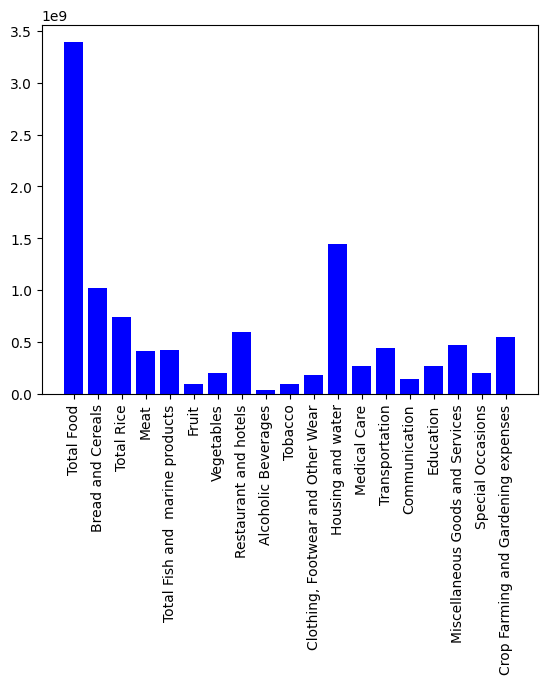

In [95]:
plt.bar(shortened_expenditures_data, data[expenditures_data].sum().values, color='blue')
plt.xticks(rotation=90)
plt.show()

### 4.2 Regional Expenditures

In [65]:
interact(bar_chart_regional_average, data=fixed(data), key=expenditures_data, average=True)

interactive(children=(Dropdown(description='key', options=('Total Food Expenditure', 'Bread and Cereals Expend…

<function utils.bar_utils.bar_chart_regional_average(data, key: str)>

In [66]:
# Summary of regional average icome and expenditures, showing the region with the highest (0) and lowest (1) average income and expenditures.
max_min_dataframe = create_dataframe_min_max(data, expenditures_data)
max_min_dataframe

,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses
0,NCR,CAR,VIII,NCR,ARMM,NCR,CAR,NCR,II,III,NCR,NCR,IV-A,NCR,NCR,NCR,NCR,IV-A,ARMM
1,X,II,IX,ARMM,X,X,X,ARMM,ARMM,CAR,ARMM,ARMM,ARMM,ARMM,ARMM,ARMM,ARMM,ARMM,NCR


NCR has the highest average food expenditures. The region also has the highest expenditures in meat, fruits, restaurant and hotels, clothing, housing and water, transportation, communication, education, and miscellaneous goods and services. Meanwhile, it had the lowest expenditures for crop farming and gardening.

Meanwhile, CALABARZON has the highest medical care and special occasions expenditures, CAR for bread and cereals, Eastern Visayas for rice, ARMM for fish and marine and crop farming and gardening, Cagayan Valley for alcoholic beverages, and Central Luzon for tobacco.

## 5. Exploring the relation between Household Income and Expenditures

### 5.1 Scatterplot

In [97]:
from utils.scatter_utils import regional_scatter_plot

In [98]:
interact(regional_scatter_plot, data=fixed(data), key=expenditures_data)

interactive(children=(Dropdown(description='key', options=('Total Food Expenditure', 'Bread and Cereals Expend…

<function utils.scatter_utils.regional_scatter_plot(data, key)>

In [99]:
from utils.regional_utils import create_dataframe_r_squared
create_dataframe_r_squared(data, expenditures_data)

,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses
0,0.859357,0.085705,0.152314,0.857656,0.006752,0.307691,0.206828,0.853440,0.205927,0.247423,0.764454,0.924941,0.670791,0.889566,0.940686,0.745108,0.918358,0.242606,0.197086
1,0.927015,0.292754,0.390274,0.926097,0.082168,0.554699,0.454783,0.923818,0.453792,0.497416,0.874331,0.961739,0.819018,0.943168,0.969890,0.863196,0.958310,0.492551,0.443944


The five expenditures that show the strongest connection (correlation) with household income are: Communication Expenditure, Miscellaneous Goods and Services Expenditure, Housing and Water Expenditure, Transportation Expenditure, and Total Food Expenditure. This means that these are the expenses that tend to move together with changes in household income and will be important features when creating a predictive model later on. These correlations are congruent to the data describing which regions have the highest expenditure for each category, i.e. NCR having the highest income also has the highest expenditures in the top 5 strongly-correlated expenditures.